# Fourier neural operator

[项目主页](https://zongyi-li.github.io/blog/2020/fourier-pde/)

[代码仓库](https://github.com/neuraloperator/neuraloperator)

## 网络结构

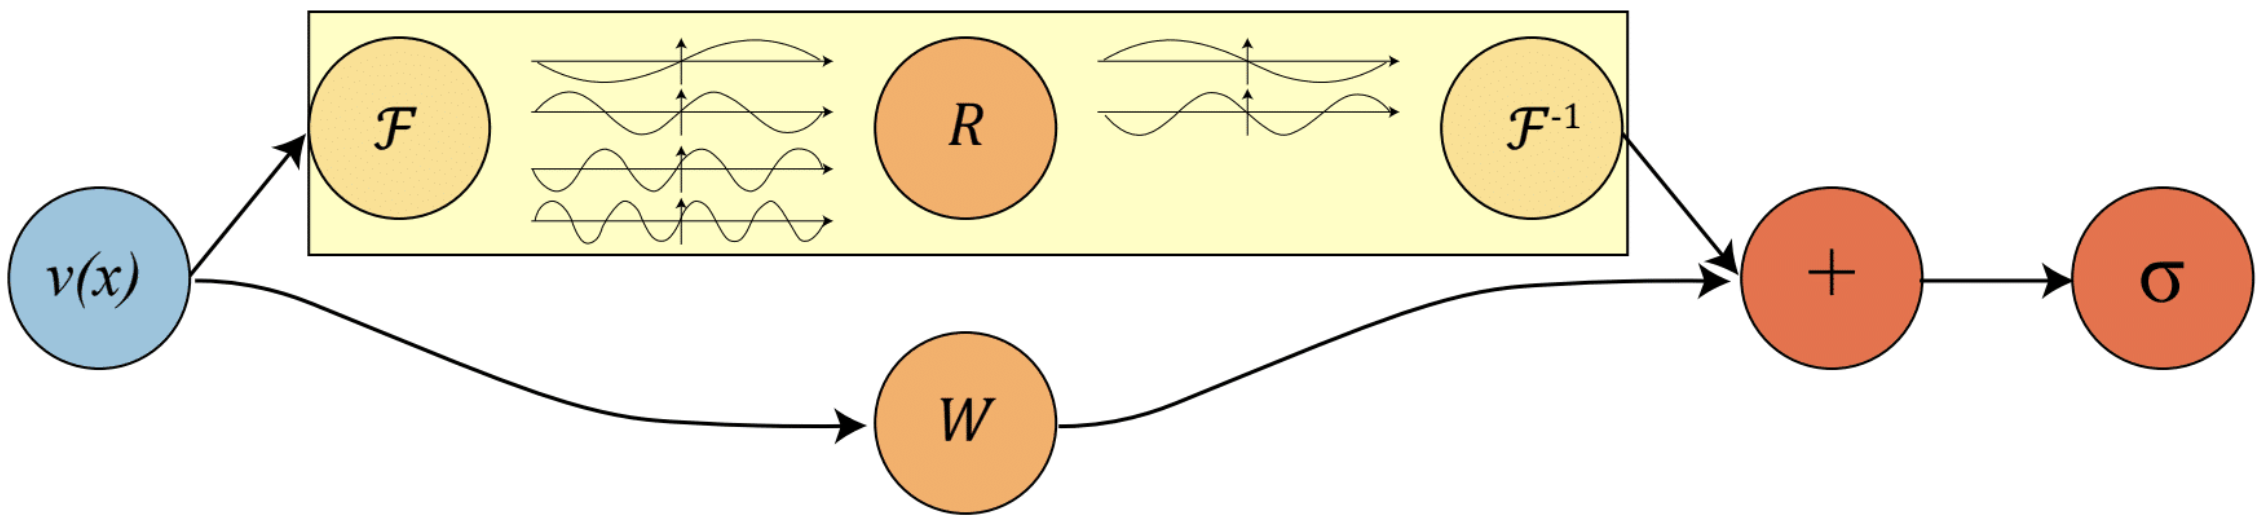


In [1]:
import torch

下面我们首先定义FNO中的单个block

In [ ]:
################################################################
#  1d fourier layer
################################################################
from functools import partial
import torch.nn.functional as F
def compl_mul1d(a, b):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    op = partial(torch.einsum, "bix,iox->box")
    return torch.stack(
        [
            op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
            op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1]),
        ],
        dim=-1,
    )

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = (
            modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        )

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, 2)
        )

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x, dim=-1, norm="ortho")
        x_ft = torch.view_as_real(x_ft)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize, self.in_channels, x.size(-1) // 2 + 1, 2, device=x.device
        )
        # print(x_ft.shape,out_ft.shape)
        out_ft[:, :, : self.modes1] = compl_mul1d(
            x_ft[:, :, : self.modes1], self.weights1
        )

        # Return to physical space
        out_ft = torch.view_as_complex(out_ft)
        x = torch.fft.irfft(out_ft, dim=-1, n=x.size(-1), norm="ortho")
        return x


class SimpleBlock1d(nn.Module):
    def __init__(self, inchannel, outchannel, modes, width, padding_mode, activation):
        super(SimpleBlock1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.inchannel = inchannel
        self.outchannel = outchannel
        self.padding_mode = padding_mode

        self.fc0 = nn.Linear(
            self.inchannel, self.width
        )  # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, self.outchannel)

        self.act=getattr(torch.nn, activation)()

    def forward(self, x):

        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = self.act(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = self.act(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = self.act(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


class FNO1d(nn.Module):
    def __init__(
        self,
        in_channel=5,
        out_channel=1,
        modes=32,
        hidden=64,
        padding_mode="circular",
        activation="ReLU",
    ):
        super(FNO1d, self).__init__()
        self.conv1 = SimpleBlock1d(
            in_channel,
            out_channel,
            modes,
            width=hidden,
            padding_mode=padding_mode,
            activation=activation,
        )
    def forward(self, x):
        x = self.conv1(x)
        return x